<a href="https://colab.research.google.com/github/umabhargavi20/Robustness-Evaluation-of-CNN-ResNet-and-CLIP-Models-Against-Adversarial-Attacks/blob/main/CIFAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/TML/RESNET_ATTACKS')

In [ ]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds

print("Tensorflow version " + tf.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Tensorflow version 2.17.1


In [ ]:
BATCH_SIZE = 32
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [ ]:
(training_images, training_labels) , (validation_images, validation_labels) = tf.keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [ ]:
def preprocess_image_input(input_images):
  input_images = input_images.astype('float32')
  output_ims = tf.keras.applications.resnet50.preprocess_input(input_images)
  return output_ims

train_X = preprocess_image_input(training_images)
valid_X = preprocess_image_input(validation_images)

In [ ]:
'''
Feature Extraction is performed by ResNet50 pretrained on imagenet weights.
Input size is 224 x 224.
'''
def feature_extractor(inputs):

  feature_extractor = tf.keras.applications.resnet.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)
  return feature_extractor


'''
Defines final dense layers and subsequent softmax layer for classification.
'''
def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(512, activation="relu")(x)
    x = tf.keras.layers.Dense(10, activation="softmax", name="classification")(x)
    return x

'''
Since input image size is (32 x 32), first upsample the image by factor of (7x7) to transform it to (224 x 224)
Connect the feature extraction and "classifier" layers to build the model.
'''
def final_model(inputs):

    resize = tf.keras.layers.UpSampling2D(size=(7,7))(inputs)

    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)

    return classification_output

'''
Define the model and compile it.
Use Stochastic Gradient Descent as the optimizer.
Use Sparse Categorical CrossEntropy as the loss function.
'''
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(32,32,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  model.compile(optimizer='SGD',
                loss='sparse_categorical_crossentropy',
                metrics = ['accuracy'])

  return model


model = define_compile_model()

model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ classification (Dense)               │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,215,818 (100.01 MB)

 Trainable params: 26,162,698 (99.80 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
EPOCHS = 3
history = model.fit(train_X, training_labels, epochs=EPOCHS, validation_data = (valid_X, validation_labels), batch_size=64)

Epoch 1/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 508s 600ms/step - accuracy: 0.7660 - loss: 0.7071 - val_accuracy: 0.9298 - val_loss: 0.2032
Epoch 2/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 448s 572ms/step - accuracy: 0.9676 - loss: 0.1033 - val_accuracy: 0.9415 - val_loss: 0.1787
Epoch 3/3
782/782 ━━━━━━━━━━━━━━━━━━━━ 446s 571ms/step - accuracy: 0.9900 - loss: 0.0352 - val_accuracy: 0.9452 - val_loss: 0.1871


In [ ]:
loss, accuracy = model.evaluate(valid_X, validation_labels, batch_size=64)

157/157 ━━━━━━━━━━━━━━━━━━━━ 25s 157ms/step - accuracy: 0.9471 - loss: 0.1772


In [ ]:
model.save('cifar10_resnet.keras')

In [ ]:
# Select 10% of the validation data for poisoning
num_validation_samples = len(valid_X)
num_poisoned_samples = int(num_validation_samples * 0.9)
poisoned_indices = np.random.choice(num_validation_samples, num_poisoned_samples, replace=False)

In [ ]:
# FGSM Attack Function
def fgsm_attack(model, images, labels, epsilon):
    with tf.GradientTape() as tape:
        images = tf.convert_to_tensor(images)  # Convert images to tf.Tensor
        labels = tf.convert_to_tensor(labels)  # Convert labels to tf.Tensor
        tape.watch(images)
        predictions = model(images)
        loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions)

    # Get the gradient of the loss with respect to the input image
    gradient = tape.gradient(loss, images)
    signed_grad = tf.sign(gradient)

    # Create the adversarial example by adjusting the input image in the direction of the gradient
    adv_images = images + epsilon * signed_grad
    adv_images = tf.clip_by_value(adv_images, -1, 1)  # Clip to ensure pixel values are valid

    return adv_images

In [ ]:
# Hyperparameters
EPSILON = 0.01  # Perturbation factor for FGSM
BATCH_SIZE = 32

In [ ]:
# Generate poisoned images
poisoned_images = []
poisoned_labels = []

for idx in poisoned_indices:
    image = valid_X[idx:idx+1]  # Get a single image (batch of size 1)
    label = validation_labels[idx:idx+1]

    # Generate adversarial example using FGSM
    adv_image = fgsm_attack(model, image, label, EPSILON)
    poisoned_images.append(adv_image)
    poisoned_labels.append(label)

# Convert poisoned images and labels to tensors
poisoned_images = tf.concat(poisoned_images, axis=0)
poisoned_labels = tf.concat(poisoned_labels, axis=0)

# Combine poisoned images with clean validation images
final_valid_X = valid_X.copy()
final_valid_X[poisoned_indices] = poisoned_images.numpy()
final_valid_labels = validation_labels  # Labels remain the same

313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 83ms/step - accuracy: 0.2346 - loss: 2.9589
Test Accuracy on Poisoned Validation Set (10% FGSM): 0.23%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


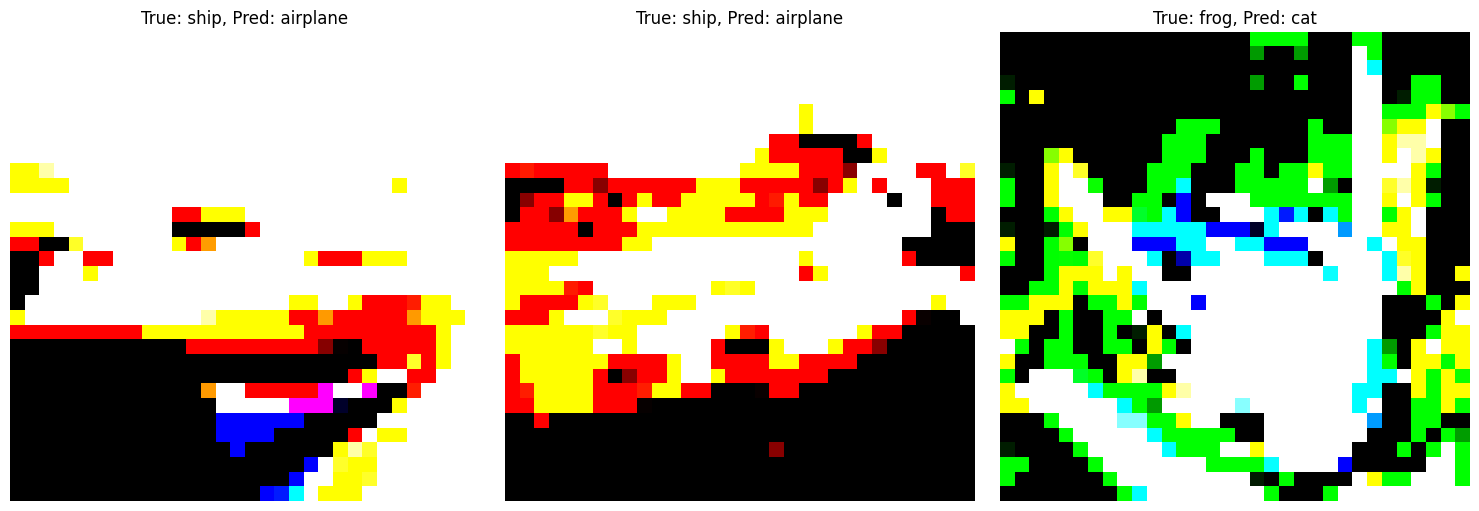

In [ ]:
# Evaluate the model on the poisoned validation set
loss, accuracy = model.evaluate(final_valid_X, final_valid_labels, batch_size=BATCH_SIZE)
print(f'Test Accuracy on Poisoned Validation Set (10% FGSM): {accuracy:.2f}%')

# Display some misclassified images
misclassified_images = []
misclassified_labels = []
correct_labels = []

# Evaluate the model and collect misclassified images
for idx in range(len(final_valid_X)):
    image = tf.convert_to_tensor(final_valid_X[idx:idx+1])  # Convert to tf.Tensor
    label = final_valid_labels[idx:idx+1]

    # Make predictions
    predictions = model.predict(image)
    predicted_label = np.argmax(predictions, axis=1)

    # Check if the image is misclassified
    if predicted_label != label:
        misclassified_images.append(image[0])
        misclassified_labels.append(predicted_label[0])
        correct_labels.append(label[0])

    # Stop after collecting 3 misclassified images
    if len(misclassified_images) >= 3:
        break

# Display misclassified images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow((misclassified_images[i] + 1) / 2)  # Convert from [-1, 1] range to [0, 1] for display
    ax.set_title(f"True: {classes[correct_labels[i][0]]}, Pred: {classes[misclassified_labels[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Spatial Attack Function (apply random rotation and translation)
def spatial_attack(images, max_rotation=20, max_translation=5):
    datagen = ImageDataGenerator(
        rotation_range=max_rotation,
        width_shift_range=max_translation / images.shape[1],  # normalize by image width
        height_shift_range=max_translation / images.shape[2]  # normalize by image height
    )

    # Generate perturbed images
    images = images.numpy() if isinstance(images, tf.Tensor) else images
    perturbed_images = []

    for img in images:
        img = img.reshape((1, *img.shape))  # Reshape to match generator's expected input
        perturbed_img = next(datagen.flow(img, batch_size=1))[0]
        perturbed_images.append(perturbed_img)

    return tf.convert_to_tensor(perturbed_images)

In [ ]:
# Apply the spatial attack on the selected 10% of the validation data
poisoned_images = spatial_attack(valid_X[poisoned_indices])

# Combine poisoned images with clean validation images
final_valid_X = valid_X.copy()
final_valid_X[poisoned_indices] = poisoned_images.numpy()
final_valid_labels = validation_labels

313/313 ━━━━━━━━━━━━━━━━━━━━ 24s 77ms/step - accuracy: 0.1141 - loss: 2.5961
Test Accuracy on Poisoned Validation Set (10% Spatial Attack): 0.11%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


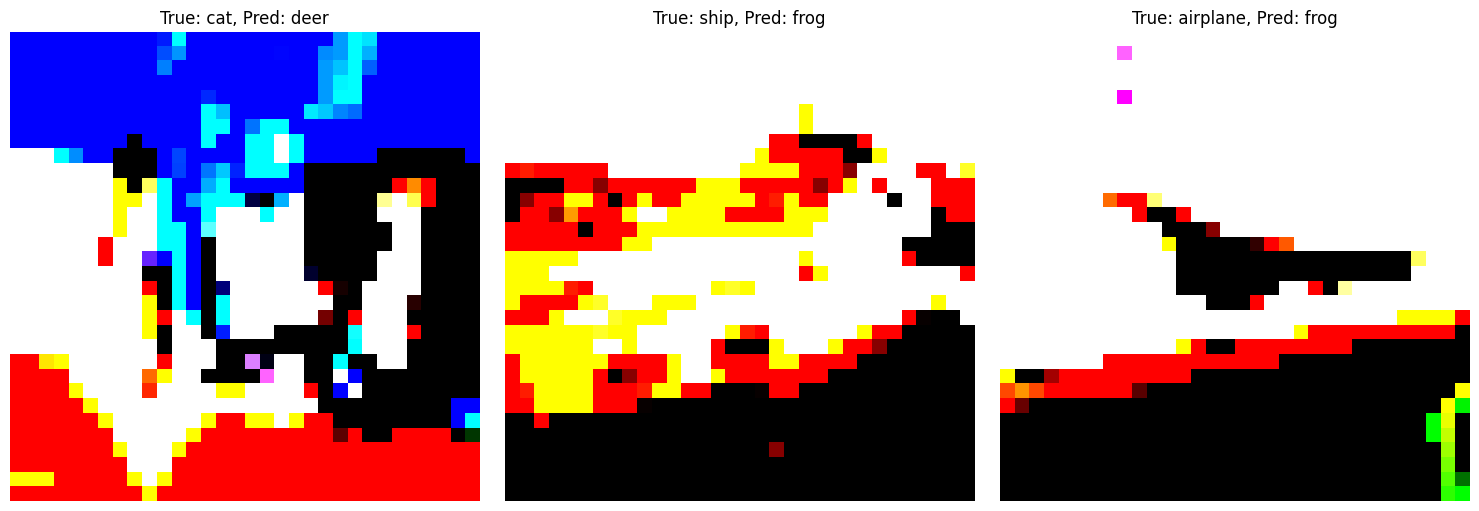

In [ ]:
# Evaluate the model on the poisoned validation set
loss, accuracy = model.evaluate(final_valid_X, final_valid_labels, batch_size=BATCH_SIZE)
print(f'Test Accuracy on Poisoned Validation Set (10% Spatial Attack): {accuracy:.2f}%')

# Display some misclassified images
misclassified_images = []
misclassified_labels = []
correct_labels = []

# Evaluate the model and collect misclassified images
for idx in range(len(final_valid_X)):
    image = tf.convert_to_tensor(final_valid_X[idx:idx+1])  # Convert to tf.Tensor
    label = final_valid_labels[idx:idx+1]

    # Make predictions
    predictions = model.predict(image)
    predicted_label = np.argmax(predictions, axis=1)

    # Check if the image is misclassified
    if predicted_label != label:
        misclassified_images.append(image[0])
        misclassified_labels.append(predicted_label[0])
        correct_labels.append(label[0])

    # Stop after collecting 3 misclassified images
    if len(misclassified_images) >= 3:
        break

# Display misclassified images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axes):
    ax.imshow((misclassified_images[i] + 1) / 2)  # Convert from [-1, 1] range to [0, 1] for display
    ax.set_title(f"True: {classes[correct_labels[i][0]]}, Pred: {classes[misclassified_labels[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()